In [1]:
import warnings
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame, Series
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import pandas as pd
import numpy as np
import dill
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv('./data_train_target.csv')
data_test = pd.read_csv('./data_test_target.csv')
X_train = data_train.drop(columns=['price'])
X_test = data_test.drop(columns=['price'])
y_train = data_train['price']
y_test = data_test['price']

In [3]:
class RandomForestMSE:
    def __init__(
        self, n_estimators, *, max_depth=None, feature_subsample_size=None,
        splitter='best', bootstrap=None, random_state=42, **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.

        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees

        bootstrap: None | int | float
            if None bootstraping is not performed. Otherwise defines splits for bootstraping

        random_state : int
            set the random state for estimators. 42 by default
        """
        self.trees = None

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.splitter = splitter
        self.random_state = random_state
        self.bootstrap = bootstrap

        # check if feature_subsample_size is in valid range of values
        if isinstance(feature_subsample_size, float) and \
                (feature_subsample_size > 1.0 or feature_subsample_size < 0.0):
            raise ValueError(
                'feature_subsample_size must be in range [0,1] or be integer')
        self.fss = feature_subsample_size if feature_subsample_size is not None else 1/3

        self.tree_parameters = trees_parameters

    def fit(self, X: np.ndarray, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        self.trees = []

        # if X or y are not numpy datastructures than redefine them
        if isinstance(X, DataFrame):
            X = X.to_numpy()
        if isinstance(y, Series):
            y = y.to_numpy()

        # generator, used in trees random_state
        rnd_gen = np.random.Generator(np.random.PCG64(self.random_state))

        # check if predefined fss is less than count of features in objects
        if (isinstance(self.fss, int) and self.fss > X.shape[1]):
            raise ValueError(
                'X have less features than expected by feature_subsample_size')

        # if bootstrapping is enabled check and prepare splitting point
        bootstrap = None
        if self.bootstrap is not None:
            if (isinstance(self.bootstrap, int) and self.bootstrap > X.shape[0] or
                    isinstance(self.bootstrap, float) and (self.bootstrap > 1.0 or self.bootstrap < 0)):
                raise ValueError('bootstrap index out of range')
            else:
                bootstrap = self.bootstrap if isinstance(
                    self.bootstrap, int) else round(self.bootstrap * X.shape[0])

        history = None
        if X_val is not None and y_val is not None:
            history = {
                'rmse': {'train': [], 'test': []},
                'r2': {'train': [], 'test': []},
                'mape': {'train': [], 'test': []},
                'mae': {'train': [], 'test': []}
            }

        for _ in range(self.n_estimators):
            idx = np.random.permutation(
                X.shape[0])[:bootstrap] if bootstrap is not None else np.arange(X.shape[0])

            # define tree structure
            tree = DecisionTreeRegressor(
                criterion='squared_error',
                splitter=self.splitter,
                max_depth=self.max_depth,
                max_features=self.fss,
                random_state=rnd_gen.integers(0, 100_000_000),
                **self.tree_parameters
            )
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)

            if history is not None:
                rmse, mae, r2, mape = self.make_metrics(X, y)
                history['rmse']['train'].append(rmse)
                history['mae']['train'].append(mae)
                history['r2']['train'].append(r2)
                history['mape']['train'].append(mape)

                rmse, mae, r2, mape = self.make_metrics(X_val, y_val)
                history['rmse']['test'].append(rmse)
                history['mae']['test'].append(mae)
                history['r2']['test'].append(r2)
                history['mape']['test'].append(mape)

        return self if history is None else history

    def make_metrics(self, X, y):
        preds = self.predict(X)

        rmse = mean_squared_error(y, preds, squared=False)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        mape = mean_absolute_percentage_error(y, preds)

        return rmse, mae, r2, mape

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        # if model is not fitted yet raise error
        if self.trees is None:
            raise ValueError('model is not fited')
        preds = np.array([tree.predict(X) for tree in self.trees])

        return np.mean(preds, axis=0)

In [ ]:
depth_rf_history = {}
for d in [3, 5, 7, 10, 15, 20, 25, 30, None]:
    tree = RandomForestMSE(150, max_depth=d)
    depth_rf_history[d] = tree.fit(X_train, y_train, X_test, y_test)
ends_rmse = [hist['rmse']['test'][-1]
             for ind, hist in depth_rf_history.items()]

In [44]:
dill.dump(ends_rmse, open('./rmse_finalls_for_rf_depth.db', 'wb'))

In [37]:
t = []
for i in range(0, 5):
    t.append(ends_rmse[i])
t.append(ends_rmse[-1])
for i in range(5, 8):
    t.append(ends_rmse[i])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


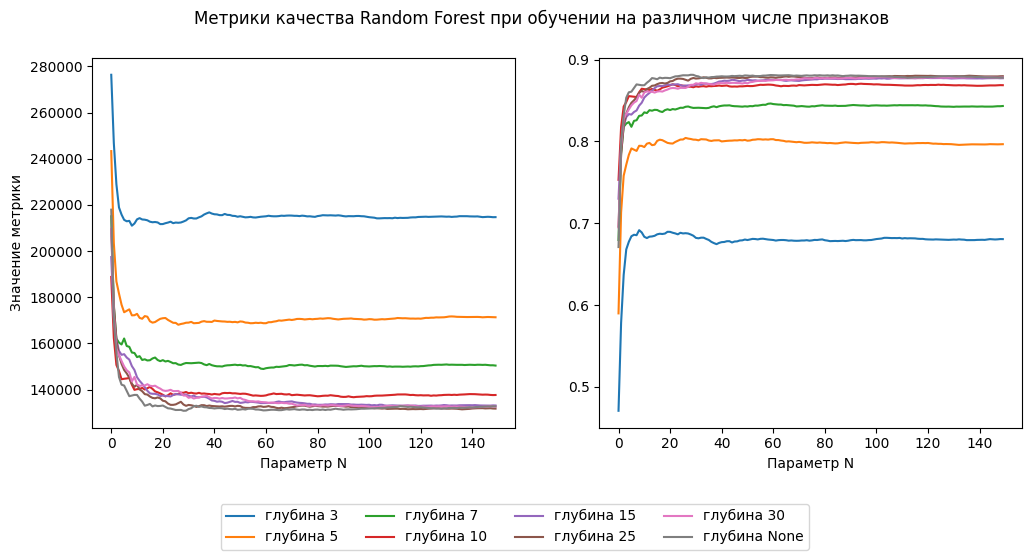

In [15]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle(
    'Метрики качества Random Forest при обучении на различном числе признаков')
axis[0].set_ylabel('Значение метрики')
axis[0].set_xlabel('Параметр N')
axis[1].set_xlabel('Параметр N')
for i, hist in depth_rf_history.items():
    axis[0].plot(np.arange(150), hist['rmse']['test'], label=f'глубина {i}')
    axis[1].plot(np.arange(150), hist['r2']['test'], label=f'глубина {i}')

plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(-0.2, -0.35))
plt.savefig('./figures/random-forest-features-settings.eps',
            format='eps', bbox_inches='tight')

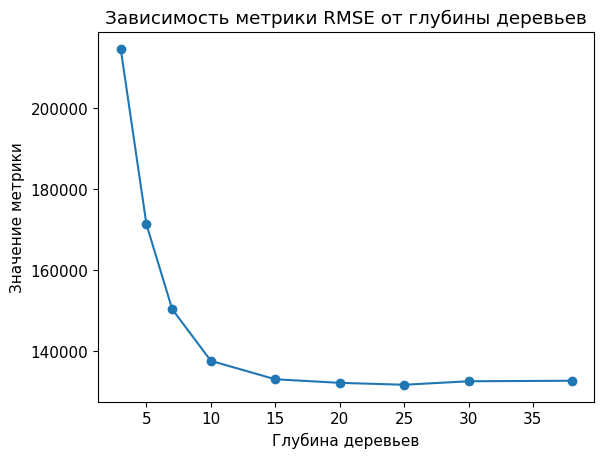

In [70]:
import matplotlib.ticker as ticker
plt.title('Зависимость метрики RMSE от глубины деревьев')
plt.scatter([3, 5, 7, 10, 15, 20, 25, 30, 38, ], t)
plt.plot([3, 5, 7, 10, 15, 20, 25, 30, 38], t)
plt.ylabel('Значение метрики')
plt.xlabel('Глубина деревьев')
plt.savefig('./figures/random-forest-depth_fet.eps',
            format='eps', bbox_inches='tight')